<a href="https://colab.research.google.com/github/rajveer43/llm_tutorials/blob/master/4_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating Finetuned Model

In this section, we demonstrate how to evaluate the previously finetuned model.

In [ ]:
! pip install transformers comet-llm comet-ml sentencepiece --quiet

In [ ]:
import os
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import transformers
import pandas as pd
import comet_llm

COMET_WORKSPACE = "WORKSPACE"
COMET_API_KEY = "API_KEY"

transformers.set_seed(35)

/Users/elvissaravia/opt/miniconda3/envs/comet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Finetuned Model

The first step is to load the finetuned model. You can load the model different ways, but in this example, we download our model and tokenizer from Comet (we stored them there in the last assignment), and then use Huggingface's Transformers library  to load the pretrained model and tokenizer.

In [ ]:
# Download model from registry:

from comet_ml import API

api = API(api_key=COMET_API_KEY)

# model name
model_name = "Emotion-T5-Base"

#get the Model object
model = api.get_model(workspace=COMET_WORKSPACE, model_name=model_name)

# Download a Registry Model:
model.download("1.0.0", "./deploy", expand=True)

The `model.download()` method will download not only the model file, but all the related assets we logged, meaning we can point Huggingface's `from_pretrained()` method directly at our download folder and everything will just work.

In [ ]:
# load model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("./deploy/checkpoint-7")
tokenizer = AutoTokenizer.from_pretrained("./deploy/checkpoint-7/")

### Load the Data to Evaluate

The next step is to load the evaluation dataset. We are reloading the dataset from the previous notebook.

In [ ]:
emotion_dataset_val_temp = pd.read_json(path_or_buf="https://raw.githubusercontent.com/comet-ml/comet-llmops/main/data/merged_training_sample_prepared_valid.jsonl", lines=True)
emotion_dataset_test = emotion_dataset_val_temp.iloc[int(len(emotion_dataset_val_temp)/2):]

In [ ]:
emotion_dataset_test.head().prompt.tolist()

['i feel very very disturbed right now i dont know how to say this but guess i couldnt sleep tonight just to think about this about him\n\n###\n\n',
 'i feel make them the most dangerous and their level of annoyance is what gives them high priority\n\n###\n\n',
 'i can feel sympathetic joy for my boyfriend and colleagues the latter being like times harder than the former\n\n###\n\n',
 'i found these emails from scott dale and just reading them frusterated me so much that i feel the need to post them and show the world what a neurotic freak he was is\n\n###\n\n',
 'i won t lie and say there isn t a part of me that still feels insulted by it\n\n###\n\n']

### Evaluate Finetuned Emotion Classifier

Evaluate different models and prompting techniques and log results when prompting the fine-tuned model. As a take-how exercise feel free to log results with few-shot and one-shot prompting using gpt-3.5-turbo. This way it will be possible to compare the finetuned model with other high-performing models.


In [ ]:
# for comet logging
comet_llm.init(project="emotion-evaluation")

# prompt prefix
prefix = "Classify the provided piece of text into one of the following emotion labels.\n\nEmotion labels: ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']\n\nText:"

# prepare prompts
prompts = [{"prompt": row.prompt.strip("\n\n###\n\n") + "\n\n" + "Emotion output:", "completion": row.completion.strip("\n").strip(" ")} for index, row in emotion_dataset_test.iterrows()]

# expected results to log
actual_completions = [prompt["completion"] for prompt in prompts]

# the results from the fine-tuned model
finetuned_completions = []

for prompt in prompts:

    # finetuned model outputs
    input_ids = tokenizer.encode(prefix + prompt["prompt"], return_tensors="pt")
    output = model.generate(input_ids, do_sample=True, max_new_tokens=1, temperature=0.1)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True).strip("<pad>").strip(" ")
    finetuned_completions.append(output_text)

    # log the prompts
    comet_llm.log_prompt(
        prompt = prefix + prompt["prompt"],
        tags = ["flan-t5-base", "fine-tuned"],
        metadata = {
            "model_name": "flan-t5-base",
            "temperature": 0.1,
            "expected_output": prompt["completion"],
        },
        output = output_text
    )

    # exercise: log zero-shot and few-shot results with GPT-3.5-Turbo and GPT-4 and compare with your fine-tuned model


Prompt logged to https://www.comet.com/omarsar/emotion-evaluation


### Finetuned Model - Confusion Matrix

Prepare a confusion matrix to better understand the performance of the fine-tuned model on the multi-label classification task.

([<matplotlib.axis.YTick at 0x7faa533cf4c0>,
 [Text(0, 0, 'anger'),
  Text(0, 1, 'fear'),
  Text(0, 2, 'joy'),
  Text(0, 3, 'love'),
  Text(0, 4, 'sadness'),
  Text(0, 5, 'surprise')])

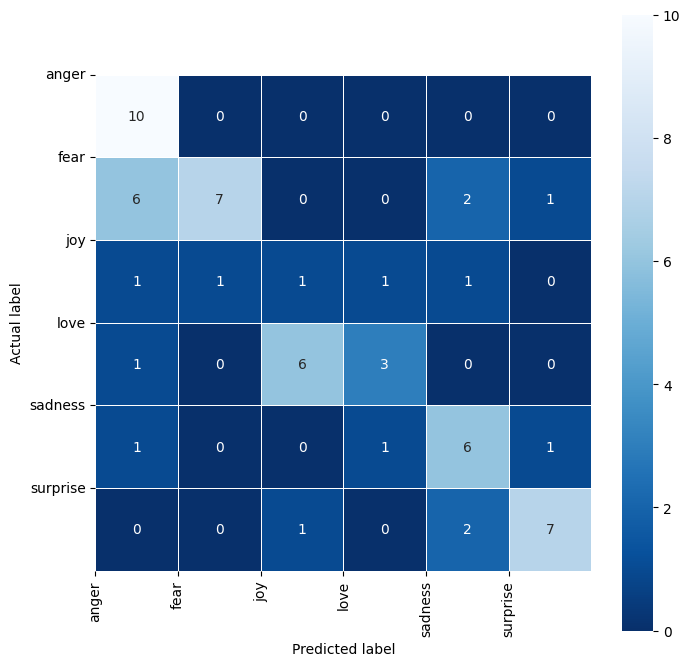

In [ ]:
# confusion matrix (logged to experiments as well)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# map completion labels to integers
completion_map = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5
}

# mapper back to string labels
completion_map_string = {
    0: "anger",
    1: "fear",
    2: "joy",
    3: "love",
    4: "sadness",
    5: "surprise"
}

actual_completions_int = [completion_map[completion] for completion in actual_completions]
finetuned_completions_int = [1 if completion == "nightmare" else completion_map[completion] for completion in finetuned_completions]

cm = confusion_matrix(actual_completions_int, finetuned_completions_int)

# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")

# add emotion labels to confusion matrix
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")

### Saving Confusion Matrix

The code below saves the confusion matrix to the selected Comet experiment. You can obtained the experiment key from Comet's experiment dashboard.

Make sure to change the experiment key to your own experiment key. Refer to the video lecture or [Comet's documentation](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/reference/ExistingExperiment/#existingexperimentlog_code) for how to locate the experiment key for your experiment.

In [ ]:
from comet_ml import ExistingExperiment

experiment = ExistingExperiment(api_key=COMET_API_KEY, previous_experiment="097ab78e6e154f24b8090a1a7dd6abb8")
experiment.log_confusion_matrix(actual_completions_int, finetuned_completions_int, labels=list(completion_map_string.values()))

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


COMET INFO: Experiment is live on comet.com https://www.comet.com/omarsar/emotion-classification/097ab78e6e154f24b8090a1a7dd6abb8



{'web': 'https://www.comet.com/api/asset/download?assetId=9f5b04f8cc7441bcb39b27de799fb2ed&experimentKey=097ab78e6e154f24b8090a1a7dd6abb8',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=9f5b04f8cc7441bcb39b27de799fb2ed&experimentKey=097ab78e6e154f24b8090a1a7dd6abb8',
 'assetId': '9f5b04f8cc7441bcb39b27de799fb2ed'}